# Multi-Ouput 모델 생성

`Functional API`를 활용하여 multi output을 출력하는 모델을 생성합니다.

## 모듈 Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

## 데이터 로드

데이터셋 다운로드 & pandas load

In [2]:
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

데이터의 구조 파악

In [3]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.76,661.5,416.5,122.5,7.0,5,0.1,2,32.41,33.78
1,0.74,686.0,245.0,220.5,3.5,2,0.4,3,13.97,16.08
2,0.76,661.5,416.5,122.5,7.0,2,0.1,5,32.31,34.25
3,0.62,808.5,367.5,220.5,3.5,3,0.1,3,12.63,14.23
4,0.90,563.5,318.5,122.5,7.0,3,0.4,5,35.01,33.14


### Feature 데이터 Standardizaiton

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(df.iloc[:, :-2])

In [5]:
train  = pd.DataFrame(scaled)
round(train.describe(), 1)

,0,1,2,3,4,5,6,7
count,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0
mean,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.4,-1.8,-1.7,-1.5,-1.0,-1.3,-1.8,-1.8
25%,-0.8,-0.7,-0.6,-0.8,-1.0,-0.7,-1.0,-0.7
50%,-0.1,0.0,0.0,0.2,0.0,0.0,0.1,0.1
75%,0.6,0.8,0.6,1.0,1.0,0.7,1.2,0.8
max,2.0,1.6,2.2,1.0,1.0,1.3,1.2,1.4


Label 데이터 확인

In [6]:
df.iloc[:, -2:].head()

,Y1,Y2
0,32.41,33.78
1,13.97,16.08
2,32.31,34.25
3,12.63,14.23
4,35.01,33.14


## 데이터 분할

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, df.iloc[:, -2:], test_size=0.2)

In [8]:
x_train

,0,1,2,3,4,5,6,7
425,-0.228616,0.162352,-1.685854,0.972512,-1.0,0.447214,-1.009323,0.120972
693,-0.512415,0.440670,-1.123903,0.972512,-1.0,1.341641,0.117363,1.411336
611,-0.985413,0.997307,0.000000,0.972512,-1.0,1.341641,1.244049,-0.524211
173,-1.363812,1.553943,1.123903,0.972512,-1.0,1.341641,1.244049,0.766154
281,0.528182,-0.672602,0.000000,-0.655880,1.0,1.341641,1.244049,-1.169393
...,...,...,...,...,...,...,...,...
243,0.906580,-0.950920,-0.561951,-0.655880,1.0,-1.341641,-1.760447,-1.814575
150,0.528182,-0.672602,0.000000,-0.655880,1.0,1.341641,1.244049,0.766154
534,-0.701614,0.718989,-0.561951,0.972512,-1.0,1.341641,-1.009323,0.766154
648,0.906580,-0.950920,-0.561951,-0.655880,1.0,0.447214,1.244049,0.766154


## 모델

모델 생성시 name을 지정하도록 합니다. 특히 output_layer에는 이름을 반드시 지정해 주어야 합니다.

그래야만 개별 **loss를 명시적으로 지정**할 수 있습니다.

In [9]:
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output layer 연결
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output layer 연결
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Model
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

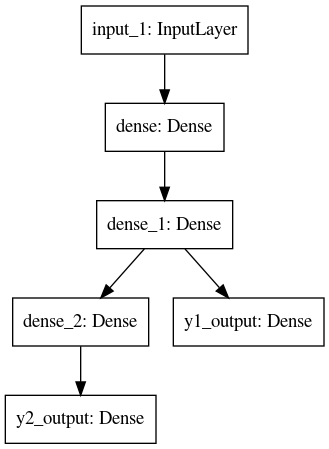

In [10]:
plot_model(model)

## optimizer, 개별 loss 정의

In [11]:
optimizer = tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## 학습 (fit)

In [12]:
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=250, 
                   )

Epoch 1/250
20/20 [==============================] - 1s 22ms/step - loss: 952.9769 - y1_output_loss: 458.4374 - y2_output_loss: 494.5396 - y1_output_root_mean_squared_error: 21.1938 - y2_output_root_mean_squared_error: 22.1154 - val_loss: 121.2354 - val_y1_output_loss: 36.0823 - val_y2_output_loss: 85.1531 - val_y1_output_root_mean_squared_error: 6.0069 - val_y2_output_root_mean_squared_error: 9.2278
Epoch 2/250
20/20 [==============================] - 0s 5ms/step - loss: 125.7652 - y1_output_loss: 40.0962 - y2_output_loss: 85.6691 - y1_output_root_mean_squared_error: 6.2979 - y2_output_root_mean_squared_error: 9.2014 - val_loss: 35.9767 - val_y1_output_loss: 17.2749 - val_y2_output_loss: 18.7018 - val_y1_output_root_mean_squared_error: 4.1563 - val_y2_output_root_mean_squared_error: 4.3246
Epoch 3/250
20/20 [==============================] - 0s 5ms/step - loss: 34.9433 - y1_output_loss: 15.1854 - y2_output_loss: 19.7578 - y1_output_root_mean_squared_error: 3.8892 - y2_output_root_mean

Epoch 22/250
20/20 [==============================] - 0s 5ms/step - loss: 14.3182 - y1_output_loss: 7.0175 - y2_output_loss: 7.3008 - y1_output_root_mean_squared_error: 2.6476 - y2_output_root_mean_squared_error: 2.6997 - val_loss: 19.2857 - val_y1_output_loss: 9.1867 - val_y2_output_loss: 10.0989 - val_y1_output_root_mean_squared_error: 3.0310 - val_y2_output_root_mean_squared_error: 3.1779
Epoch 23/250
20/20 [==============================] - 0s 5ms/step - loss: 18.9121 - y1_output_loss: 8.6715 - y2_output_loss: 10.2406 - y1_output_root_mean_squared_error: 2.9400 - y2_output_root_mean_squared_error: 3.1916 - val_loss: 15.4213 - val_y1_output_loss: 7.5481 - val_y2_output_loss: 7.8733 - val_y1_output_root_mean_squared_error: 2.7474 - val_y2_output_root_mean_squared_error: 2.8059
Epoch 24/250
20/20 [==============================] - 0s 5ms/step - loss: 12.1798 - y1_output_loss: 6.0675 - y2_output_loss: 6.1123 - y1_output_root_mean_squared_error: 2.4569 - y2_output_root_mean_squared_erro

Epoch 43/250
20/20 [==============================] - 0s 5ms/step - loss: 8.1281 - y1_output_loss: 4.1674 - y2_output_loss: 3.9608 - y1_output_root_mean_squared_error: 2.0406 - y2_output_root_mean_squared_error: 1.9890 - val_loss: 9.2814 - val_y1_output_loss: 4.4633 - val_y2_output_loss: 4.8182 - val_y1_output_root_mean_squared_error: 2.1126 - val_y2_output_root_mean_squared_error: 2.1950
Epoch 44/250
20/20 [==============================] - 0s 5ms/step - loss: 7.6977 - y1_output_loss: 3.9409 - y2_output_loss: 3.7568 - y1_output_root_mean_squared_error: 1.9821 - y2_output_root_mean_squared_error: 1.9366 - val_loss: 8.5451 - val_y1_output_loss: 4.3849 - val_y2_output_loss: 4.1602 - val_y1_output_root_mean_squared_error: 2.0940 - val_y2_output_root_mean_squared_error: 2.0397
Epoch 45/250
20/20 [==============================] - 0s 5ms/step - loss: 7.5196 - y1_output_loss: 3.8606 - y2_output_loss: 3.6590 - y1_output_root_mean_squared_error: 1.9643 - y2_output_root_mean_squared_error: 1.91

Epoch 64/250
20/20 [==============================] - 0s 5ms/step - loss: 6.0198 - y1_output_loss: 3.0036 - y2_output_loss: 3.0162 - y1_output_root_mean_squared_error: 1.7328 - y2_output_root_mean_squared_error: 1.7365 - val_loss: 6.4349 - val_y1_output_loss: 3.1811 - val_y2_output_loss: 3.2539 - val_y1_output_root_mean_squared_error: 1.7835 - val_y2_output_root_mean_squared_error: 1.8039
Epoch 65/250
20/20 [==============================] - 0s 5ms/step - loss: 6.6546 - y1_output_loss: 3.3303 - y2_output_loss: 3.3243 - y1_output_root_mean_squared_error: 1.8230 - y2_output_root_mean_squared_error: 1.8216 - val_loss: 6.2954 - val_y1_output_loss: 3.1598 - val_y2_output_loss: 3.1355 - val_y1_output_root_mean_squared_error: 1.7776 - val_y2_output_root_mean_squared_error: 1.7707
Epoch 66/250
20/20 [==============================] - 0s 5ms/step - loss: 5.9167 - y1_output_loss: 2.9491 - y2_output_loss: 2.9676 - y1_output_root_mean_squared_error: 1.7172 - y2_output_root_mean_squared_error: 1.72

Epoch 85/250
20/20 [==============================] - 0s 5ms/step - loss: 6.0557 - y1_output_loss: 3.0009 - y2_output_loss: 3.0548 - y1_output_root_mean_squared_error: 1.7314 - y2_output_root_mean_squared_error: 1.7464 - val_loss: 6.2439 - val_y1_output_loss: 3.1401 - val_y2_output_loss: 3.1039 - val_y1_output_root_mean_squared_error: 1.7720 - val_y2_output_root_mean_squared_error: 1.7618
Epoch 86/250
20/20 [==============================] - 0s 5ms/step - loss: 5.6127 - y1_output_loss: 2.7965 - y2_output_loss: 2.8162 - y1_output_root_mean_squared_error: 1.6712 - y2_output_root_mean_squared_error: 1.6770 - val_loss: 6.3672 - val_y1_output_loss: 3.1461 - val_y2_output_loss: 3.2211 - val_y1_output_root_mean_squared_error: 1.7737 - val_y2_output_root_mean_squared_error: 1.7947
Epoch 87/250
20/20 [==============================] - 0s 5ms/step - loss: 5.5915 - y1_output_loss: 2.7852 - y2_output_loss: 2.8063 - y1_output_root_mean_squared_error: 1.6684 - y2_output_root_mean_squared_error: 1.67

Epoch 106/250
20/20 [==============================] - 0s 5ms/step - loss: 5.4839 - y1_output_loss: 2.7288 - y2_output_loss: 2.7551 - y1_output_root_mean_squared_error: 1.6513 - y2_output_root_mean_squared_error: 1.6592 - val_loss: 6.1391 - val_y1_output_loss: 3.0552 - val_y2_output_loss: 3.0839 - val_y1_output_root_mean_squared_error: 1.7479 - val_y2_output_root_mean_squared_error: 1.7561
Epoch 107/250
20/20 [==============================] - 0s 5ms/step - loss: 5.6495 - y1_output_loss: 2.7949 - y2_output_loss: 2.8545 - y1_output_root_mean_squared_error: 1.6716 - y2_output_root_mean_squared_error: 1.6894 - val_loss: 6.5844 - val_y1_output_loss: 3.2869 - val_y2_output_loss: 3.2975 - val_y1_output_root_mean_squared_error: 1.8130 - val_y2_output_root_mean_squared_error: 1.8159
Epoch 108/250
20/20 [==============================] - 0s 5ms/step - loss: 5.8786 - y1_output_loss: 2.9123 - y2_output_loss: 2.9663 - y1_output_root_mean_squared_error: 1.7064 - y2_output_root_mean_squared_error: 1

Epoch 127/250
20/20 [==============================] - 0s 5ms/step - loss: 6.2151 - y1_output_loss: 3.0904 - y2_output_loss: 3.1247 - y1_output_root_mean_squared_error: 1.7570 - y2_output_root_mean_squared_error: 1.7669 - val_loss: 6.2131 - val_y1_output_loss: 3.1184 - val_y2_output_loss: 3.0947 - val_y1_output_root_mean_squared_error: 1.7659 - val_y2_output_root_mean_squared_error: 1.7592
Epoch 128/250
20/20 [==============================] - 0s 5ms/step - loss: 5.9327 - y1_output_loss: 2.9369 - y2_output_loss: 2.9958 - y1_output_root_mean_squared_error: 1.7136 - y2_output_root_mean_squared_error: 1.7306 - val_loss: 6.3990 - val_y1_output_loss: 3.1264 - val_y2_output_loss: 3.2726 - val_y1_output_root_mean_squared_error: 1.7682 - val_y2_output_root_mean_squared_error: 1.8090
Epoch 129/250
20/20 [==============================] - 0s 5ms/step - loss: 5.8880 - y1_output_loss: 2.9385 - y2_output_loss: 2.9496 - y1_output_root_mean_squared_error: 1.7135 - y2_output_root_mean_squared_error: 1

Epoch 148/250
20/20 [==============================] - 0s 5ms/step - loss: 5.6119 - y1_output_loss: 2.7892 - y2_output_loss: 2.8227 - y1_output_root_mean_squared_error: 1.6690 - y2_output_root_mean_squared_error: 1.6790 - val_loss: 6.5085 - val_y1_output_loss: 3.2443 - val_y2_output_loss: 3.2641 - val_y1_output_root_mean_squared_error: 1.8012 - val_y2_output_root_mean_squared_error: 1.8067
Epoch 149/250
20/20 [==============================] - 0s 5ms/step - loss: 5.6159 - y1_output_loss: 2.7768 - y2_output_loss: 2.8392 - y1_output_root_mean_squared_error: 1.6653 - y2_output_root_mean_squared_error: 1.6839 - val_loss: 6.2876 - val_y1_output_loss: 3.1536 - val_y2_output_loss: 3.1340 - val_y1_output_root_mean_squared_error: 1.7758 - val_y2_output_root_mean_squared_error: 1.7703
Epoch 150/250
20/20 [==============================] - 0s 5ms/step - loss: 5.6852 - y1_output_loss: 2.8251 - y2_output_loss: 2.8601 - y1_output_root_mean_squared_error: 1.6806 - y2_output_root_mean_squared_error: 1

Epoch 169/250
20/20 [==============================] - 0s 5ms/step - loss: 6.4654 - y1_output_loss: 3.0212 - y2_output_loss: 3.4442 - y1_output_root_mean_squared_error: 1.7372 - y2_output_root_mean_squared_error: 1.8554 - val_loss: 6.2735 - val_y1_output_loss: 3.0657 - val_y2_output_loss: 3.2078 - val_y1_output_root_mean_squared_error: 1.7509 - val_y2_output_root_mean_squared_error: 1.7910
Epoch 170/250
20/20 [==============================] - 0s 5ms/step - loss: 5.4718 - y1_output_loss: 2.6959 - y2_output_loss: 2.7759 - y1_output_root_mean_squared_error: 1.6413 - y2_output_root_mean_squared_error: 1.6655 - val_loss: 5.9715 - val_y1_output_loss: 2.9787 - val_y2_output_loss: 2.9928 - val_y1_output_root_mean_squared_error: 1.7259 - val_y2_output_root_mean_squared_error: 1.7300
Epoch 171/250
20/20 [==============================] - 0s 5ms/step - loss: 5.3904 - y1_output_loss: 2.6776 - y2_output_loss: 2.7127 - y1_output_root_mean_squared_error: 1.6360 - y2_output_root_mean_squared_error: 1

Epoch 190/250
20/20 [==============================] - 0s 5ms/step - loss: 5.9369 - y1_output_loss: 2.9288 - y2_output_loss: 3.0081 - y1_output_root_mean_squared_error: 1.7098 - y2_output_root_mean_squared_error: 1.7323 - val_loss: 6.1643 - val_y1_output_loss: 3.0301 - val_y2_output_loss: 3.1342 - val_y1_output_root_mean_squared_error: 1.7407 - val_y2_output_root_mean_squared_error: 1.7704
Epoch 191/250
20/20 [==============================] - 0s 5ms/step - loss: 5.4844 - y1_output_loss: 2.7089 - y2_output_loss: 2.7755 - y1_output_root_mean_squared_error: 1.6453 - y2_output_root_mean_squared_error: 1.6657 - val_loss: 5.9467 - val_y1_output_loss: 2.9775 - val_y2_output_loss: 2.9692 - val_y1_output_root_mean_squared_error: 1.7255 - val_y2_output_root_mean_squared_error: 1.7231
Epoch 192/250
20/20 [==============================] - 0s 5ms/step - loss: 4.9031 - y1_output_loss: 2.4540 - y2_output_loss: 2.4492 - y1_output_root_mean_squared_error: 1.5652 - y2_output_root_mean_squared_error: 1

Epoch 211/250
20/20 [==============================] - 0s 5ms/step - loss: 4.9252 - y1_output_loss: 2.4557 - y2_output_loss: 2.4695 - y1_output_root_mean_squared_error: 1.5650 - y2_output_root_mean_squared_error: 1.5694 - val_loss: 6.1520 - val_y1_output_loss: 3.0775 - val_y2_output_loss: 3.0745 - val_y1_output_root_mean_squared_error: 1.7543 - val_y2_output_root_mean_squared_error: 1.7534
Epoch 212/250
20/20 [==============================] - 0s 5ms/step - loss: 5.5971 - y1_output_loss: 2.8027 - y2_output_loss: 2.7944 - y1_output_root_mean_squared_error: 1.6733 - y2_output_root_mean_squared_error: 1.6709 - val_loss: 5.9702 - val_y1_output_loss: 2.9901 - val_y2_output_loss: 2.9801 - val_y1_output_root_mean_squared_error: 1.7292 - val_y2_output_root_mean_squared_error: 1.7263
Epoch 213/250
20/20 [==============================] - 0s 5ms/step - loss: 6.0980 - y1_output_loss: 3.0180 - y2_output_loss: 3.0800 - y1_output_root_mean_squared_error: 1.7366 - y2_output_root_mean_squared_error: 1

Epoch 232/250
20/20 [==============================] - 0s 5ms/step - loss: 5.4058 - y1_output_loss: 2.6934 - y2_output_loss: 2.7124 - y1_output_root_mean_squared_error: 1.6406 - y2_output_root_mean_squared_error: 1.6464 - val_loss: 6.0998 - val_y1_output_loss: 3.0423 - val_y2_output_loss: 3.0575 - val_y1_output_root_mean_squared_error: 1.7442 - val_y2_output_root_mean_squared_error: 1.7486
Epoch 233/250
20/20 [==============================] - 0s 5ms/step - loss: 5.2771 - y1_output_loss: 2.6361 - y2_output_loss: 2.6410 - y1_output_root_mean_squared_error: 1.6228 - y2_output_root_mean_squared_error: 1.6242 - val_loss: 5.9858 - val_y1_output_loss: 2.9805 - val_y2_output_loss: 3.0053 - val_y1_output_root_mean_squared_error: 1.7264 - val_y2_output_root_mean_squared_error: 1.7336
Epoch 234/250
20/20 [==============================] - 0s 5ms/step - loss: 5.9656 - y1_output_loss: 2.9775 - y2_output_loss: 2.9881 - y1_output_root_mean_squared_error: 1.7242 - y2_output_root_mean_squared_error: 1

결과 시각화를 위한 함수

In [13]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Evaluate

In [14]:
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x_test, y_test)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 2ms/step - loss: 6.0033 - y1_output_loss: 3.0104 - y2_output_loss: 2.9929 - y1_output_root_mean_squared_error: 1.7351 - y2_output_root_mean_squared_error: 1.7300
Loss = 6.003305912017822, Y1_loss = 3.0104222297668457, Y1_mse = 1.7350568771362305, Y2_loss = 2.9928836822509766, Y2_mse = 1.7299952507019043


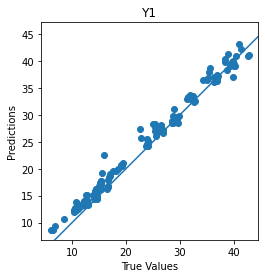

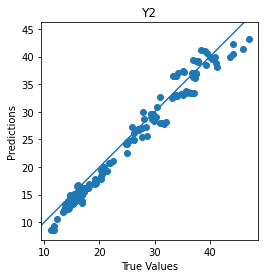

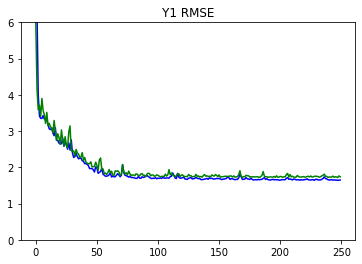

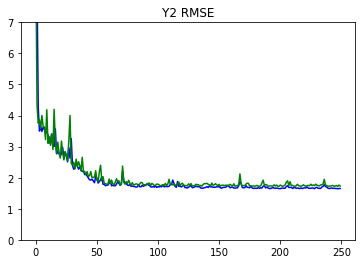

In [15]:
# Plot the loss and mse
y_pred = model.predict(x_test)
plot_diff(y_test.iloc[:, 0], y_pred[0], title='Y1')
plot_diff(y_test.iloc[:, 1], y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)